In [7]:
!pip install matplotlib
!pip install tensorflow==2.8.0
!pip install tensorflow-io==0.25.0

  Using cached tensorflow_io-0.25.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached tensorflow_io_gcs_filesystem-0.25.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
Using cached tensorflow_io-0.25.0-cp310-cp310-win_amd64.whl (21.8 MB)
Using cached tensorflow_io_gcs_filesystem-0.25.0-cp310-cp310-win_amd64.whl (1.5 MB)
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.31.0
    Uninstalling tensorflow-io-gcs-filesystem-0.31.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.31.0


In [3]:
!pip install "numpy<2"

   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   ----------- ---------------------------- 4.5/15.8 MB 24.4 MB/s eta 0:00:01
   --------------- ------------------------ 6.3/15.8 MB 24.1 MB/s eta 0:00:01
   ---------------------------- ----------- 11.3/15.8 MB 19.6 MB/s eta 0:00:01
   ---------------------------------------  15.7/15.8 MB 20.6 MB/s eta 0:00:01
   ---------------------------------------- 15.8/15.8 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.0
    Uninstalling numpy-2.2.0:
      Successfully uninstalled numpy-2.2.0


  You can safely remove it manually.
  You can safely remove it manually.


In [1]:
!conda list

# packages in environment at C:\Users\foxir\miniconda3\envs\gunshot_tf:
#
# Name                    Version                   Build  Channel
absl-py                   2.1.0                    pypi_0    pypi
asttokens                 3.0.0                    pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
bzip2                     1.0.8                h2466b09_7    conda-forge
ca-certificates           2024.12.14           h56e8100_0    conda-forge
cachetools                5.5.0                    pypi_0    pypi
certifi                   2024.12.14               pypi_0    pypi
charset-normalizer        3.4.0                    pypi_0    pypi
colorama                  0.4.6                    pypi_0    pypi
comm                      0.2.2                    pypi_0    pypi
contourpy                 1.3.1                    pypi_0    pypi
cudatoolkit               11.2.2              h7d7167e_13    conda-forge
cudnn                     8.1.0.77            

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np

In [1]:
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data = os.path.join('belize-data')
train_dir = os.path.join('belize-data', 'Training data')
val_dir = os.path.join('belize-data', 'Validation data')
val_NEG = os.path.join('belize-data', 'Validation data', 'Background')
val_POS = os.path.join('belize-data', 'Validation data', 'Gunshot')
NEG = os.path.join('belize-data', 'Training data', 'Background')
POS = os.path.join('belize-data', 'Training data', 'Gunshot')
model_save_dir = os.path.join('model','model_exports')
outputs_dir = os.path.join('outputs')

In [4]:
def load_wav_8k_mono(filename):
    try:
        file_contents = tf.io.read_file(filename)
        wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
        sample_rate = tf.cast(sample_rate, dtype=tf.int64)
        if sample_rate != 8000:
            wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=8000)
        wav = tf.squeeze(wav, axis=-1)
    except Exception as e:
        print(f"Invalid file: {file_path} - {e}")
    return wav

In [5]:
sample_rate = 8000
mel_spec_length = 32000
frame_length = 256
frame_step = 128
mel_bins = 64
upper_edge = 4000
lower_edge = 0

In [6]:
def preprocess_mel(file_path, label):
    # load wav and make sure length is proper
    try:
        wav = load_wav_8k_mono(file_path)
    except Exception as e:
        print(f"Failed to load wav file at {file_path} - {e}")
    if len(wav) > 32000:
        wav = wav[:mel_spec_length]
    if len(wav) < 32000:
        try:
            zero_padding = tf.zeros([mel_spec_length] - tf.shape(wav), dtype=tf.float32)
            wav = tf.concat([zero_padding, wav], 0)
        except Exception as e:
            print(f"Failed to pad wav file at {file_path} - {e}")

    # create the spectrogram
    print("Wav Shape:", wav.shape)
    spectrogram = tf.signal.stft(wav, frame_length, frame_step, window_fn=tf.signal.hann_window)
    print("STFT Shape1:", spectrogram.shape)
    spectrogram = tf.abs(spectrogram)
    print("STFT Shape2:", spectrogram.shape)

    # create the mel filterbank
    spec_bins = frame_length // 2 + 1  # Derived from frame length
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
        mel_bins,
        spec_bins,
        sample_rate,
        lower_edge,
        upper_edge,
    )
    print("Mel Filterbank Shape:", mel_filterbank.shape)
    
    # create the mel spectrogram
    mel_spectrogram = tf.matmul(spectrogram, mel_filterbank)
    print("Mel Spectrogram Shape1:", mel_spectrogram.shape)

    # add a dimension
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=2)
    print("Mel Spectrogram Shape2:", mel_spectrogram.shape)

    return mel_spectrogram, label

In [17]:
def validate_wav(file_path):
    try:
        audio = tf.audio.decode_wav(tf.io.read_file(file_path))
        return True
    except Exception as e:
        print(f"Invalid file: {file_path} - {e}")
        return False
audio_dir = train_NEG_dir
for file in os.listdir(audio_dir):
    if not validate_wav(os.path.join(audio_dir, file)):
        print(f"Removing invalid file: {file}")
        os.remove(os.path.join(audio_dir, file))

Invalid file: belize-data\Training data\Background\603EEE5A.WAV - Data too short when trying to read string [Op:DecodeWav]
Removing invalid file: 603EEE5A.WAV
Invalid file: belize-data\Training data\Background\603EFD8C.WAV - Data too short when trying to read string [Op:DecodeWav]
Removing invalid file: 603EFD8C.WAV


In [7]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
training_data = positives.concatenate(negatives)

In [8]:
data = training_data
data = data.map(preprocess_mel)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>


In [9]:
train = data.take(1050)
test = data.skip(1050).take(750)
samples, labels = train.as_numpy_iterator().next()

In [10]:
num_batches = sum(1 for _ in data)
take_batches = min(36, num_batches)
print(num_batches)
print(take_batches)

1800
36


In [11]:
for element in data.take(1):
    print(element)

(<tf.Tensor: shape=(16, 249, 64, 1), dtype=float32, numpy=
array([[[[0.4873563 ],
         [0.472433  ],
         [0.03011996],
         ...,
         [0.10411777],
         [0.13753256],
         [0.14183141]],

        [[0.50179094],
         [0.48652118],
         [0.03209993],
         ...,
         [0.10466237],
         [0.09911799],
         [0.10287978]],

        [[0.48620364],
         [0.4716964 ],
         [0.03438338],
         ...,
         [0.08550307],
         [0.11126374],
         [0.09207398]],

        ...,

        [[0.45728505],
         [0.44556567],
         [0.05425132],
         ...,
         [0.12089761],
         [0.11736937],
         [0.12857181]],

        [[0.5013229 ],
         [0.48600826],
         [0.03139658],
         ...,
         [0.3373828 ],
         [0.2866004 ],
         [0.249138  ]],

        [[0.5147688 ],
         [0.5005475 ],
         [0.04936099],
         ...,
         [0.15137328],
         [0.17502123],
         [0.13649993]]],


 

In [12]:
def take_element_and_label(dataset):
    for batch, labels in dataset.take(1):
        singular_element = batch[0]  # Get the first element in the batch
        singular_label = labels[0]  # Get the corresponding label
    return singular_element, singular_label

In [13]:
def take_element_of_class(dataset, target_label):
    for batch, labels in dataset:
        for i, label in enumerate(labels):
            if label == target_label:
                singular_element = batch[i]
                label = labels[i]
                return singular_element, label
    else:
        print(f"No matching element of label {target_label} found")
    return None, None

1.0
(249, 64, 1)


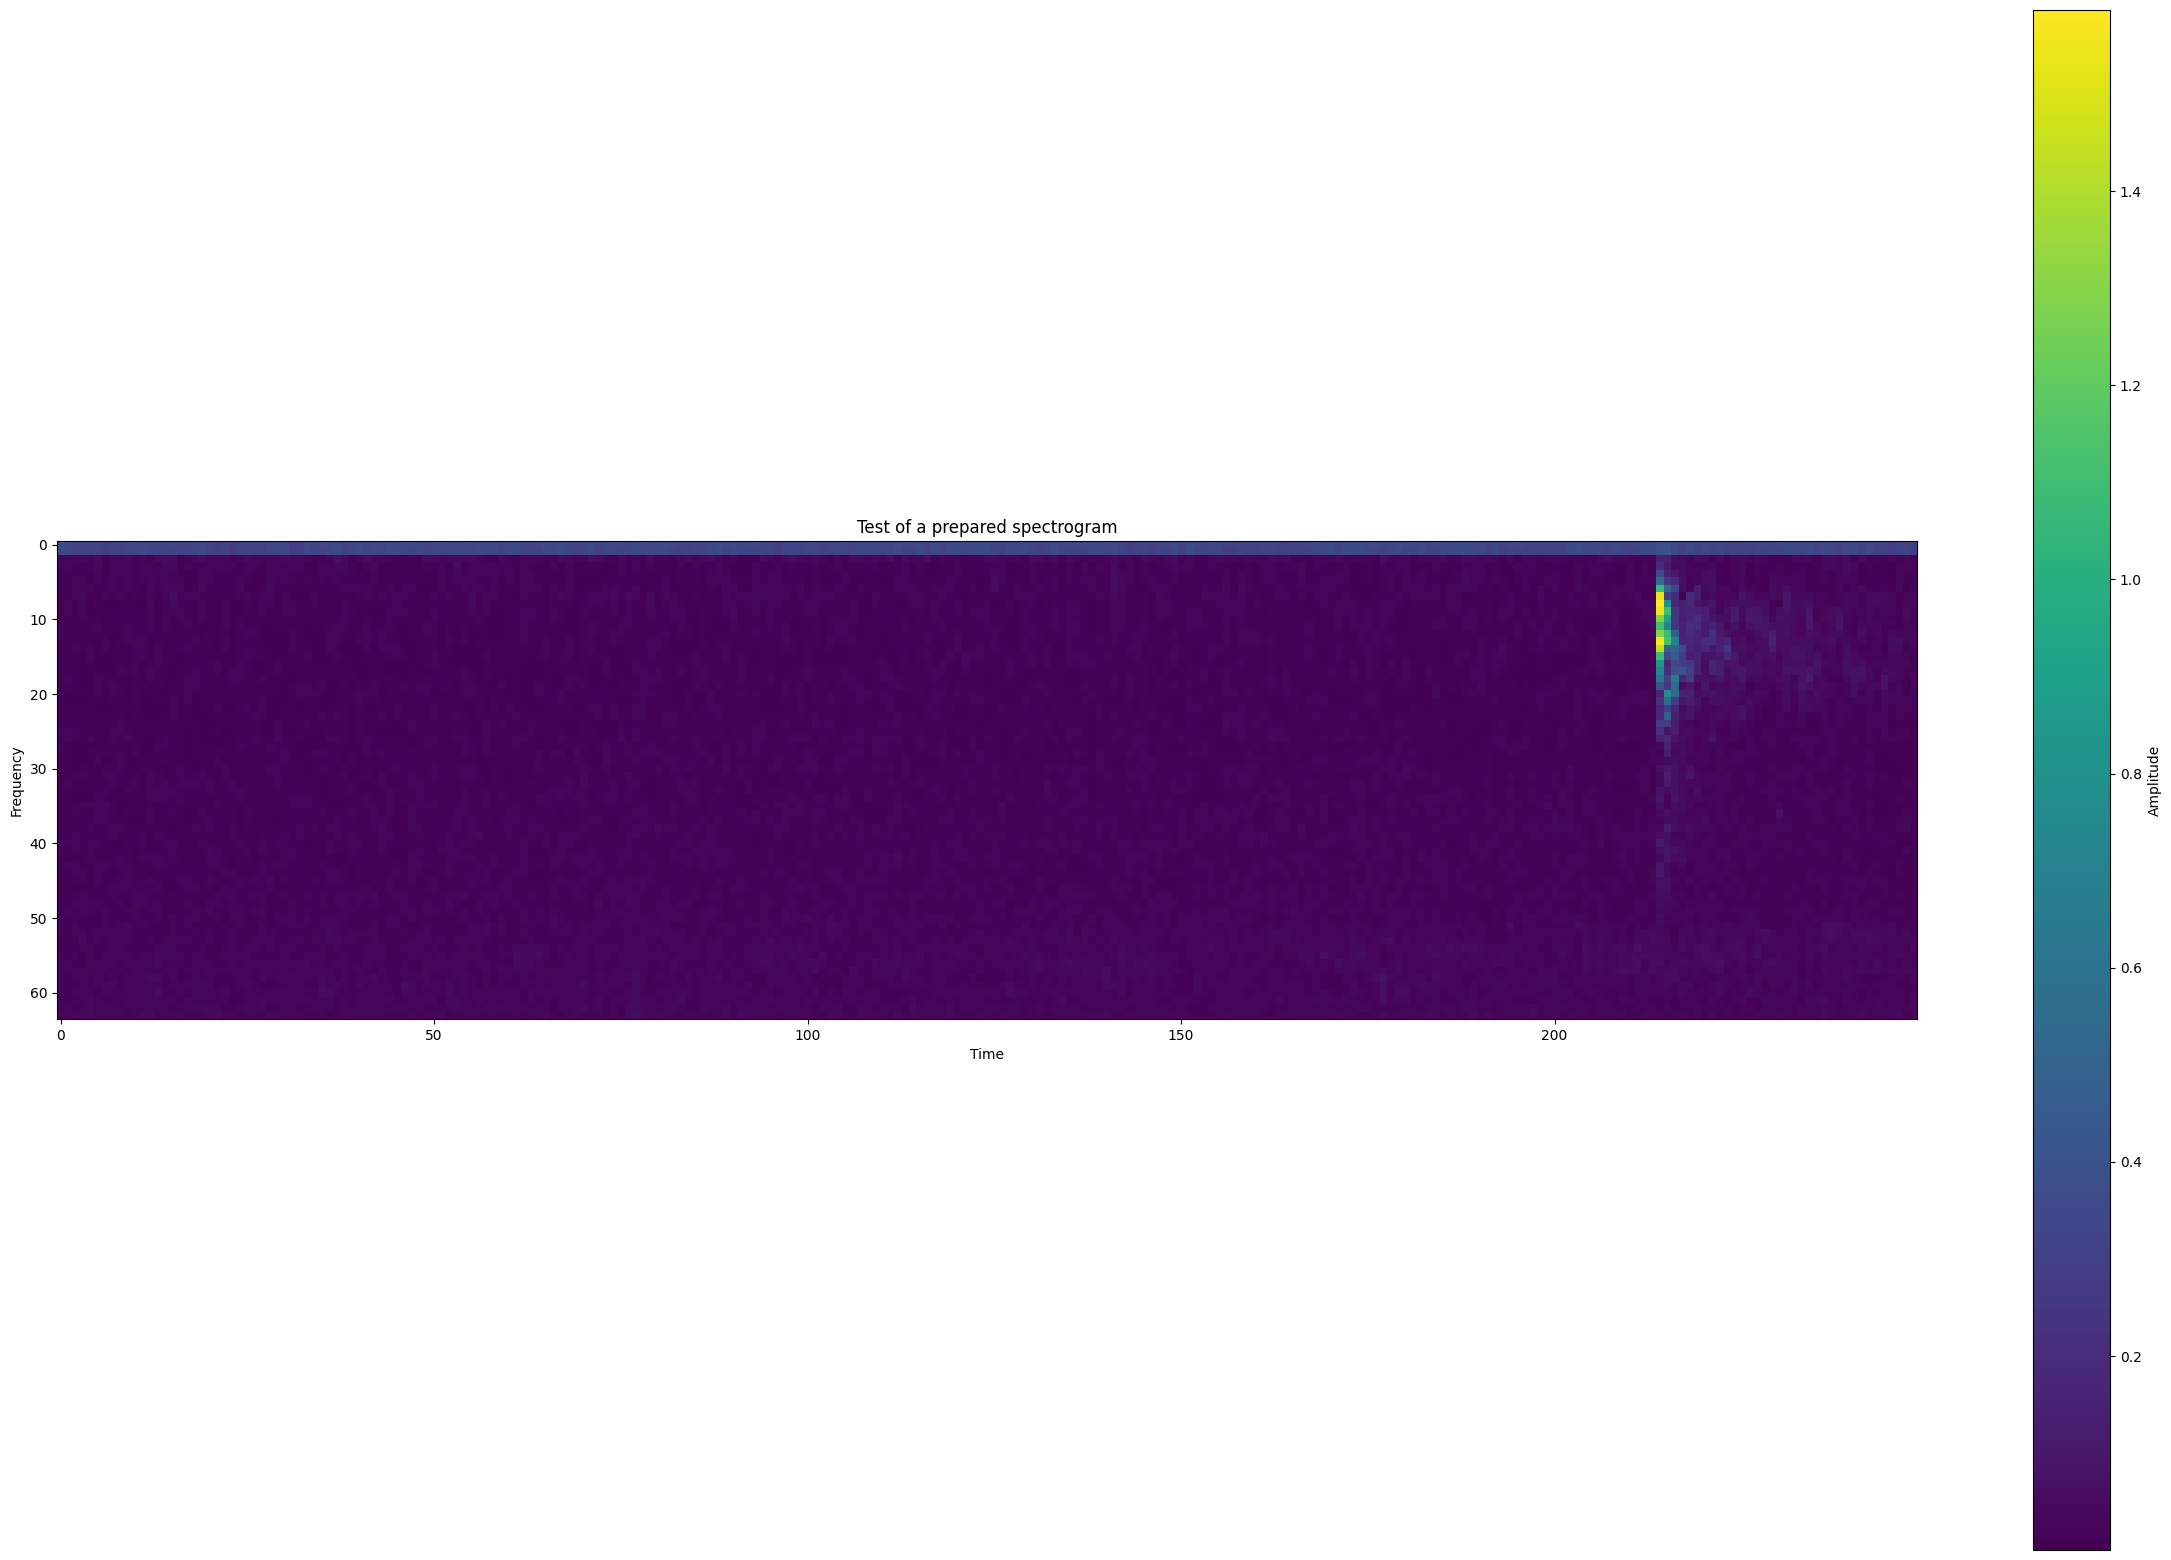

In [14]:
singular_element, label = take_element_of_class(data, 1)
print(label.numpy())
prepared_spectrogram = singular_element
print(prepared_spectrogram.shape)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(prepared_spectrogram)[0])
plt.colorbar(label="Amplitude")
plt.title("Test of a prepared spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

1.0
(249, 64, 1)


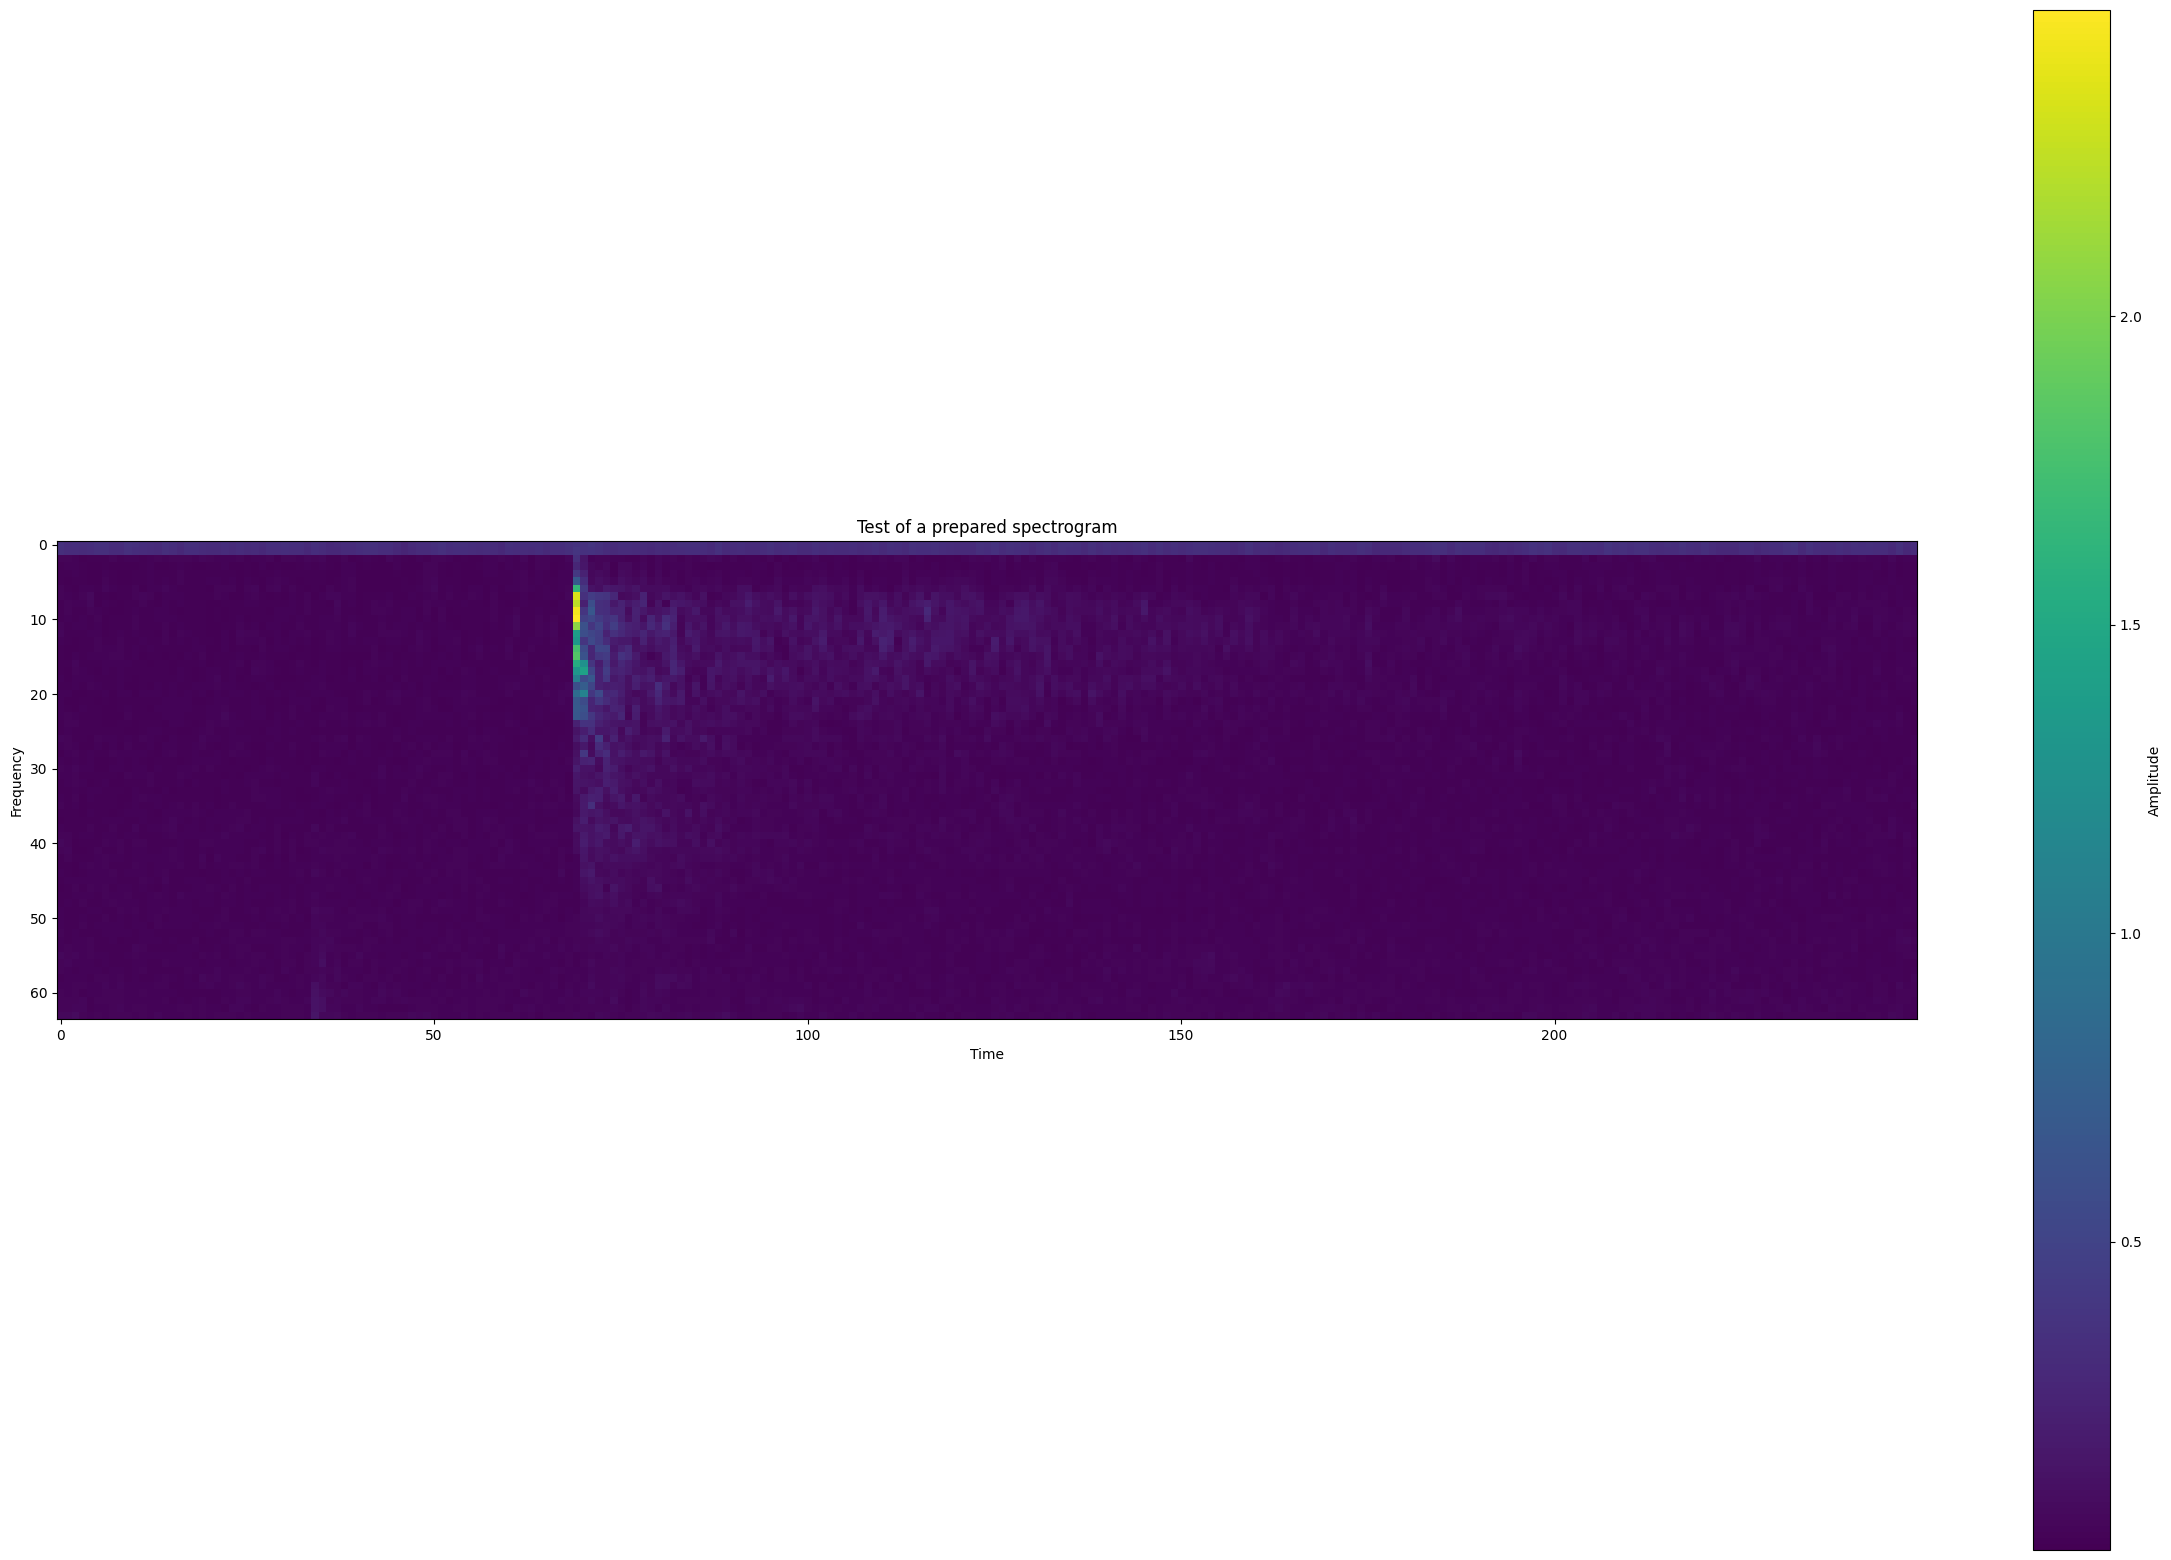

In [23]:
singular_element, singular_label = take_element_and_label(data)
print(singular_label.numpy())
prepared_spectrogram = singular_element
# prepared_spectrogram = tf.squeeze(singular_element, axis=-1)
print(prepared_spectrogram.shape)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(prepared_spectrogram)[0])
plt.colorbar(label="Amplitude")
plt.title("Test of a prepared spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

In [25]:
model=Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(249, 64,1)))
model.add(Conv2D(16, (3,3), activation='relu'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 247, 62, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 245, 60, 16)       2320      
                                                                 
 flatten (Flatten)           (None, 235200)            0         
                                                                 
 dense (Dense)               (None, 128)               30105728  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 30,108,337
Trainable params: 30,108,337
Non-trainable params: 0
_________________________________________________________________


In [26]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 5s 86ms/step - loss: 0.9314 - recall: 0.6151 - precision: 0.6653 - val_loss: 0.4731 - val_recall: 0.2143 - val_precision: 0.7895
Epoch 2/4
36/36 [==============================] - 3s 80ms/step - loss: 0.5725 - recall: 0.7538 - precision: 0.6700 - val_loss: 0.4382 - val_recall: 0.6712 - val_precision: 0.6806
Epoch 3/4
36/36 [==============================] - 3s 80ms/step - loss: 0.4679 - recall: 0.8148 - precision: 0.7612 - val_loss: 0.4255 - val_recall: 0.8533 - val_precision: 0.6809
Epoch 4/4
36/36 [==============================] - 3s 80ms/step - loss: 0.3992 - recall: 0.8491 - precision: 0.7979 - val_loss: 0.3711 - val_recall: 0.9189 - val_precision: 0.6939


# 1/3/25, 6:39PM, Belize dataset, no augmentations, 30M parameter old Sequenti